In [1]:
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from ewtpy import EWT1D
from scipy import stats
from scipy import signal
import matplotlib as mpl
mpl.rcParams['figure.dpi'] = 150

In [2]:
def get_mat_voltage(plot=True):
    """
    sampling rate: 10Hz
    """
    filepath = "Cycling_1/W8.mat"
    f = loadmat(filepath)
    # print(f.keys())

    current = f['I_full_vec_M1_NMC25degC']
    time = f['t_full_vec_M1_NMC25degC']
    voltage = f['V_full_vec_M1_NMC25degC']
    step = f['Step_Index_full_vec_M1_NMC25degC']
    if plot:
        plt.plot(step, c='black', label='step')
        plt.plot(voltage, c='blue', label='voltage')
        plt.xlabel('time(s)')
        plt.legend()
        plt.show()
        plt.close()
    return voltage, step

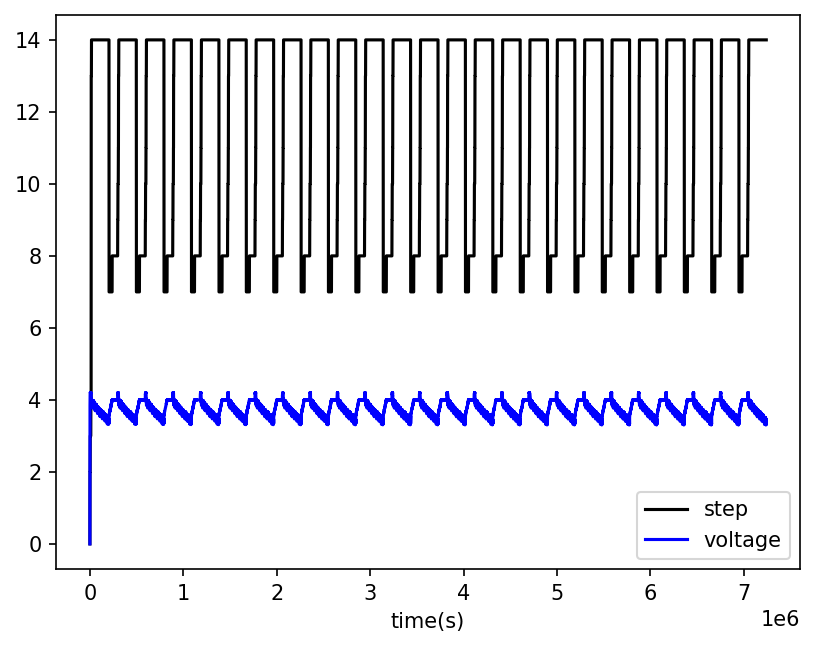

discharge segments=24


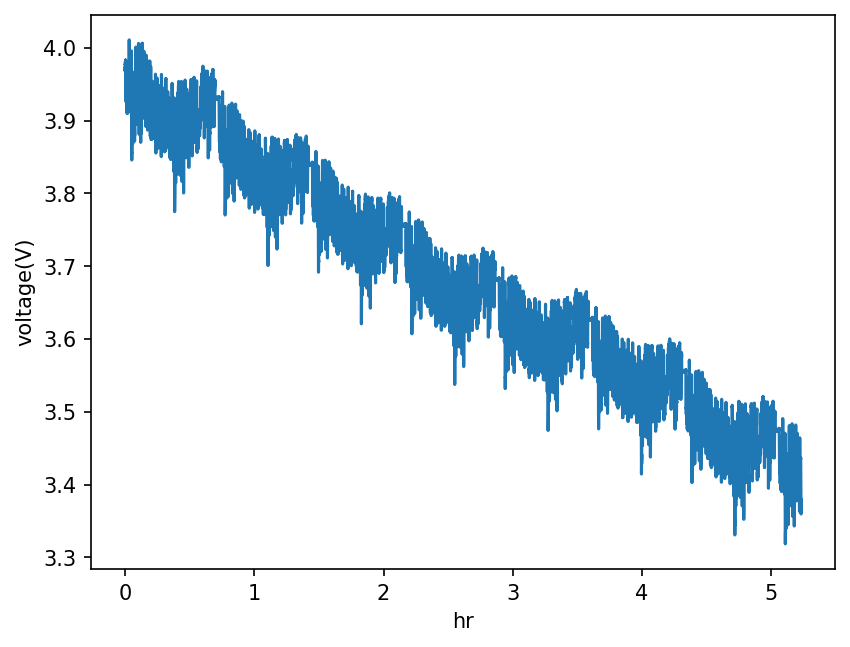

In [3]:
v, s = get_mat_voltage()

# extract discharge part
v[s!=14] = 0
dif = np.abs(np.diff(v, axis=0))
edge = np.argwhere(dif>1)+1
dc_v = [v[edge[i, 0]:edge[i+1, 0]] for i in range(0, len(edge)-1, 2)]
print('discharge segments=%d'%len(dc_v))
plt.plot(np.arange(len(dc_v[0]))/36000, dc_v[0])
plt.xlabel('hr')
plt.ylabel('voltage(V)')
plt.show()
plt.close()

(36000, 9)
(71999, 9)


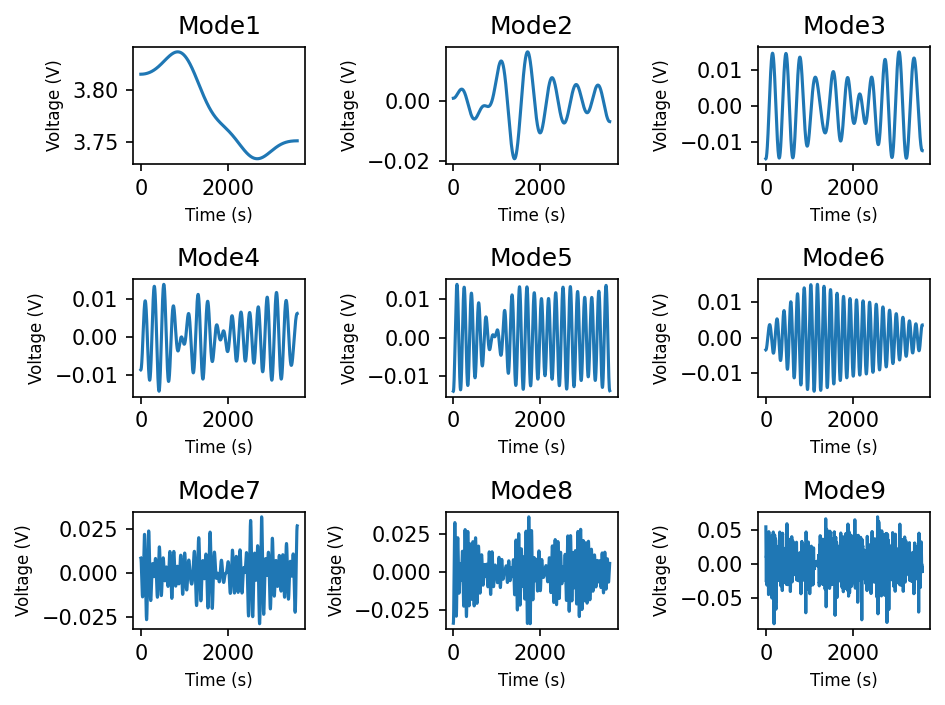

In [4]:
# extract voltage information within 1hr to apply EWT
ewt, mfb ,boundaries = EWT1D(dc_v[0][40000:76000, 0], N=9, reg='gaussian')
print(ewt.shape)
print(mfb.shape)
fig, ax = plt.subplots(3, 3)

for i in range(9):
    ax[i//3,i%3].plot(np.linspace(0, 3600, 36000), ewt[:, i])
    ax[i//3,i%3].set_title('Mode%d'%(i+1))
    ax[i//3,i%3].set_xlabel('Time (s)', fontsize=8)
    ax[i//3,i%3].set_ylabel('Voltage (V)', fontsize=8)
plt.tight_layout()
plt.show()
plt.close()

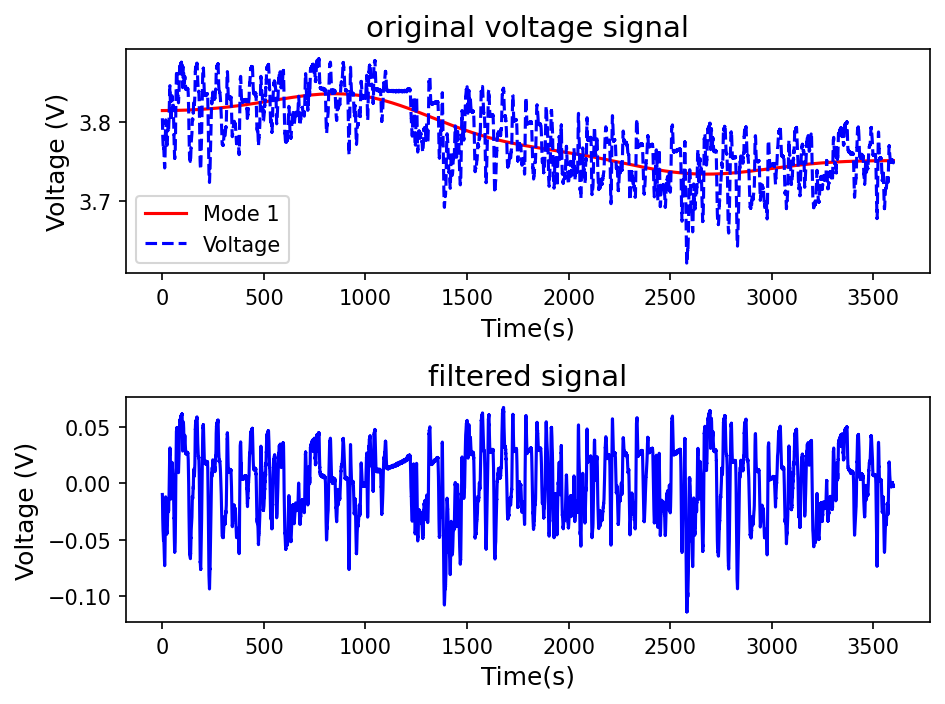

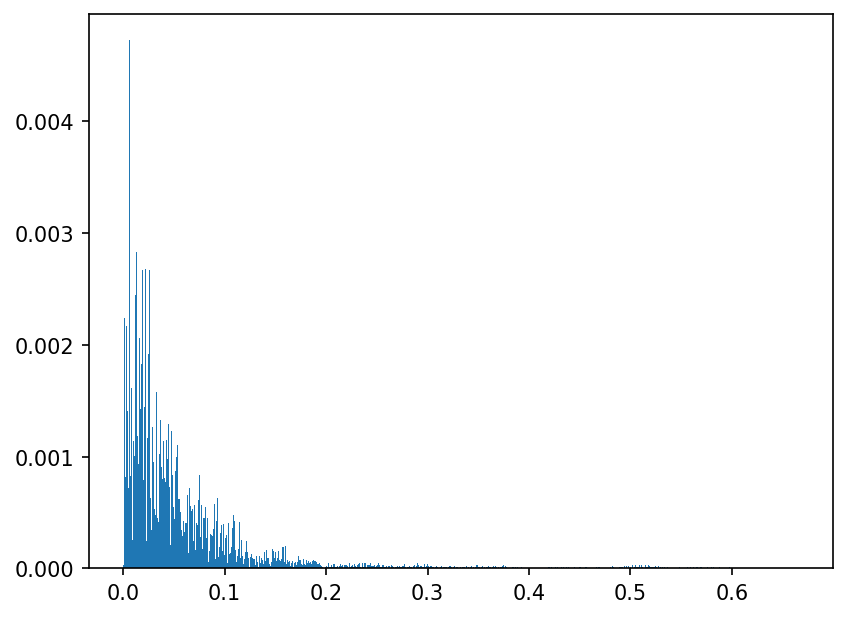

In [5]:
# fundamental mode filtering
v_t = dc_v[0][40000:76000, 0]
corr = np.array([np.corrcoef(ewt[:, mode], v_t)[0, 1] for mode in range(9)])

fig, ax = plt.subplots(2, 1)

f_mode = ewt[:, np.argmax(corr)]
ax[0].plot(np.linspace(0, 3600, 36000), f_mode, c='red', label='Mode 1') # fundamental mode
ax[0].plot(np.linspace(0, 3600, 36000), v_t, c='blue', ls='--', label='Voltage') # original signal
ax[0].set_xlabel('Time(s)', fontsize=12)
ax[0].set_ylabel('Voltage (V)', fontsize=12)
ax[0].set_title('original voltage signal', fontsize=14)
ax[0].legend()

v_c = v_t-ewt[:, np.argmax(corr)] # filtered signal
ax[1].plot(np.linspace(0, 3600, 36000),v_c, c='blue')
ax[1].set_xlabel('Time(s)', fontsize=12)
ax[1].set_ylabel('Voltage (V)', fontsize=12)
ax[1].set_title('filtered signal', fontsize=14)
plt.tight_layout()
plt.show()
plt.close()

# filtered signal fft
sp = np.fft.rfft(v_c, norm='forward')
freq = np.fft.rfftfreq(v_c.shape[-1], d=0.1)
plt.bar(freq[:2400], np.abs(sp)[:2400], width=5/18000)
plt.show()
plt.close()

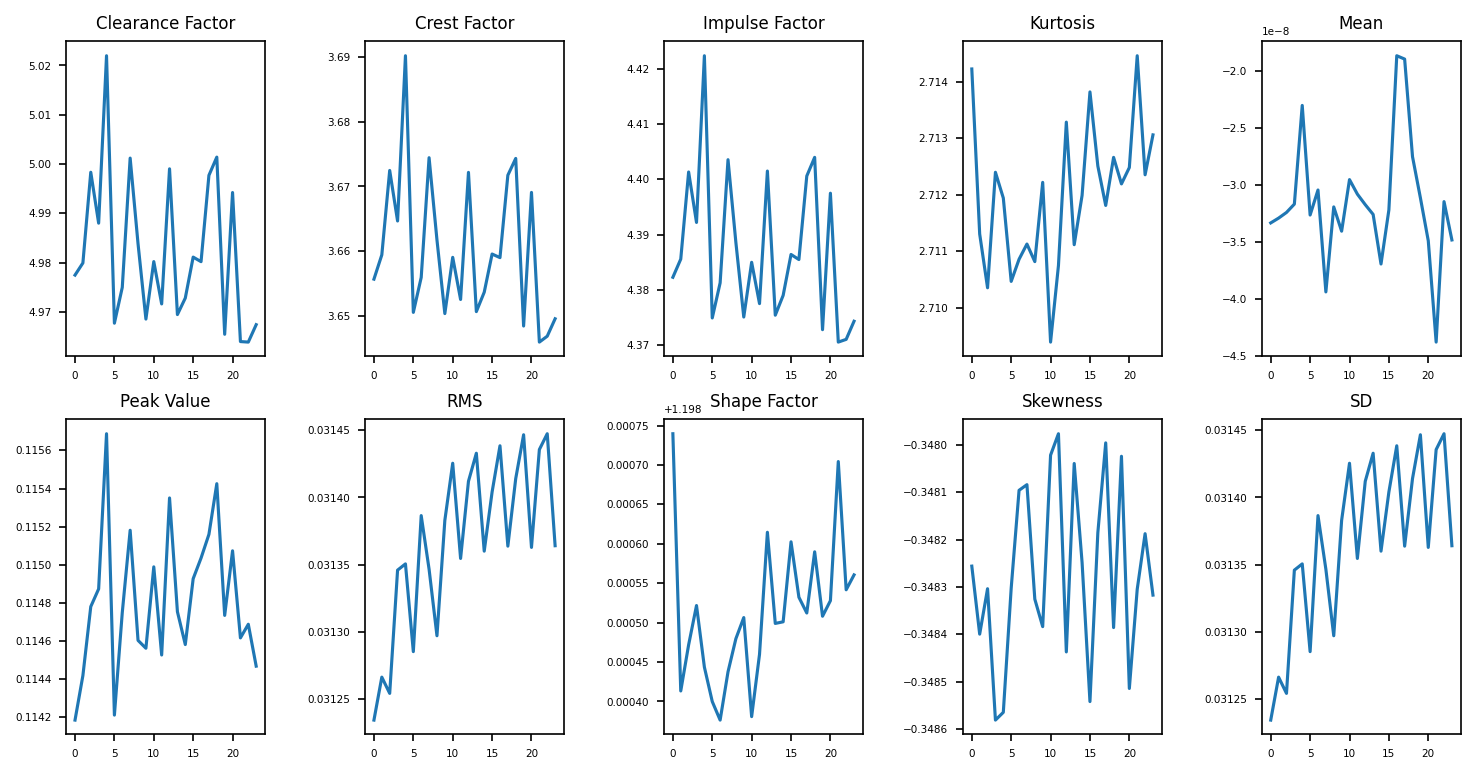

In [17]:
# feature extraction
def feature_extraction(v):
    v_abs = np.abs(v)

    v_peak = np.max(v_abs) # peak value
    sd = np.std(v) # standard deviation
    m = np.mean(v) # mean
    kur = np.mean((v-m)**4)/sd**4 # kurtosis  
    skew = np.mean((v-m)**3)/sd**3 # skewness
    rms = np.sqrt(np.mean(v**2)) # RMS
    snr =  m/sd # SNR
    cl_f = v_peak/((np.mean(np.sqrt(v_abs)))**2) # clearance factor
    cr_f = v_peak/np.sqrt(np.mean(v**2)) # crest factor
    ip_f = v_peak/np.mean(v_abs) # impulse factor   
    sh_f = rms/np.mean(v_abs) # shape factor
    return [cl_f, cr_f, ip_f, kur, m, v_peak, rms, sh_f, skew, sd]

feature_names = ['Clearance Factor', 'Crest Factor', 'Impulse Factor', 'Kurtosis', 'Mean', 'Peak Value', 'RMS', 'Shape Factor', 'Skewness', 'SD']
feature_list = []
for i in range(len(dc_v)):
    v_t = dc_v[i][40000:76000, 0]
    ewt, mfb ,boundaries = EWT1D(v_t, N=9)
    
    corr = np.array([np.corrcoef(ewt[:, mode], v_t)[0, 1] for mode in range(9)])
    f_mode = ewt[:, np.argmax(corr)]
    v_c = v_t-f_mode 
    feature_list.append(feature_extraction(v_c))

feature_list = np.vstack(feature_list)
fig, ax = plt.subplots(2, 5, figsize=(12, 6))
for i in range(10):
    ax[i//5,i%5].plot(feature_list[:, i])
    ax[i//5,i%5].set_title(feature_names[i], fontsize=8)
    ax[i//5,i%5].tick_params(axis='x', labelsize=5)
    ax[i//5,i%5].tick_params(axis='y', labelsize=5)
    ax[i//5,i%5].yaxis.get_offset_text().set(size=5)
plt.subplots_adjust(wspace=0.5, hspace=0.2)
plt.show()
plt.close()
